In [1]:
# !pip install --user scikit-surprise

In [2]:
from surprise import Reader, Dataset
import pandas as pd
import random
import numpy as np

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

In [ ]:
%%bigquery df_blackfriday_data
select * from `blackfridayintelia.blackfriday.blackfriday`

In [3]:
# %store -r df_blackfriday_data

In [4]:
ratings_dict = {'itemID': list(df_blackfriday_data.Product_ID),
                'userID': list(df_blackfriday_data.User_ID),
                'rating': list((df_blackfriday_data.Purchase.pow(1/2)-3.464)/15)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(0, 10.0))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [5]:
from surprise import accuracy, Dataset, SVD, NMF, KNNBasic, CoClustering, SlopeOne, SVDpp, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import train_test_split, GridSearchCV


# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, random_state=random_seed, test_size=0.25)

# We'll use the famous SVD algorithm.
# algo = SVD()
# algo = KNNBaseline()
# algo = SlopeOne()
# for algo in [SVD(n_factors=18), SVD(n_factors=19), SVD(n_factors=20), SVD(n_factors=21), SVD(n_factors=22)]:
#     print('!!!!!!!!')
#     print(algo)
#     print()

#     # Train the algorithm on the trainset, and predict ratings for the testset
#     algo.fit(trainset)
#     predictions = algo.test(testset)

#     # Then compute RMSE
#     accuracy.rmse(predictions)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8756
0.8755809608071079


## Grid Search

In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print(sqrt(mean_squared_error([(x.r_ui*15 +3.464)*(x.r_ui*15 +3.464) for x in predictions], [(x.est*15 +3.464)*(x.est*15 +3.464) for x in predictions])))


2504.5524970490205


In [7]:

df_test = pd.DataFrame({'User_ID':[x.uid for x in predictions], 
                        'Product_ID': [x.iid for x in predictions], 
                        'y_pred': [x.est*x.est*225 +3.464 for x in predictions],
                        'y': [x.r_ui*x.r_ui*225 +3.464 for x in predictions]})

df = pd.merge(df_test, df_blackfriday_data, on=['User_ID', 'Product_ID'], how='inner')

df

,User_ID,Product_ID,y_pred,y,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1004144,P00210942,5878.590086,6453.080459,M,18-25,4,C,3,0,5,12.0,NaN,7018
1,1001647,P00048142,9693.658032,14669.461382,M,18-25,18,B,0,0,1,16.0,NaN,15517
2,1001926,P00323942,8762.760423,9366.106246,F,0-17,0,B,1,0,8,15.0,NaN,10045
3,1003499,P00046142,14983.263968,14476.985097,M,26-35,3,A,2,0,1,16.0,NaN,15319
4,1001897,P00042742,5852.780214,4904.455635,F,51-55,2,A,1,1,5,14.0,NaN,5398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137512,1004993,P00040642,3915.476080,1578.513875,M,46-50,17,C,2,0,5,NaN,NaN,1862
137513,1003921,P00022542,4664.922110,7995.128455,M,26-35,14,C,2,1,5,NaN,NaN,8623
137514,1002252,P00319042,7090.008002,6391.732894,F,18-25,1,B,1,0,5,NaN,NaN,6954
137515,1002257,P00001742,8127.721316,5623.111956,F,18-25,4,B,2,0,8,14.0,NaN,6151


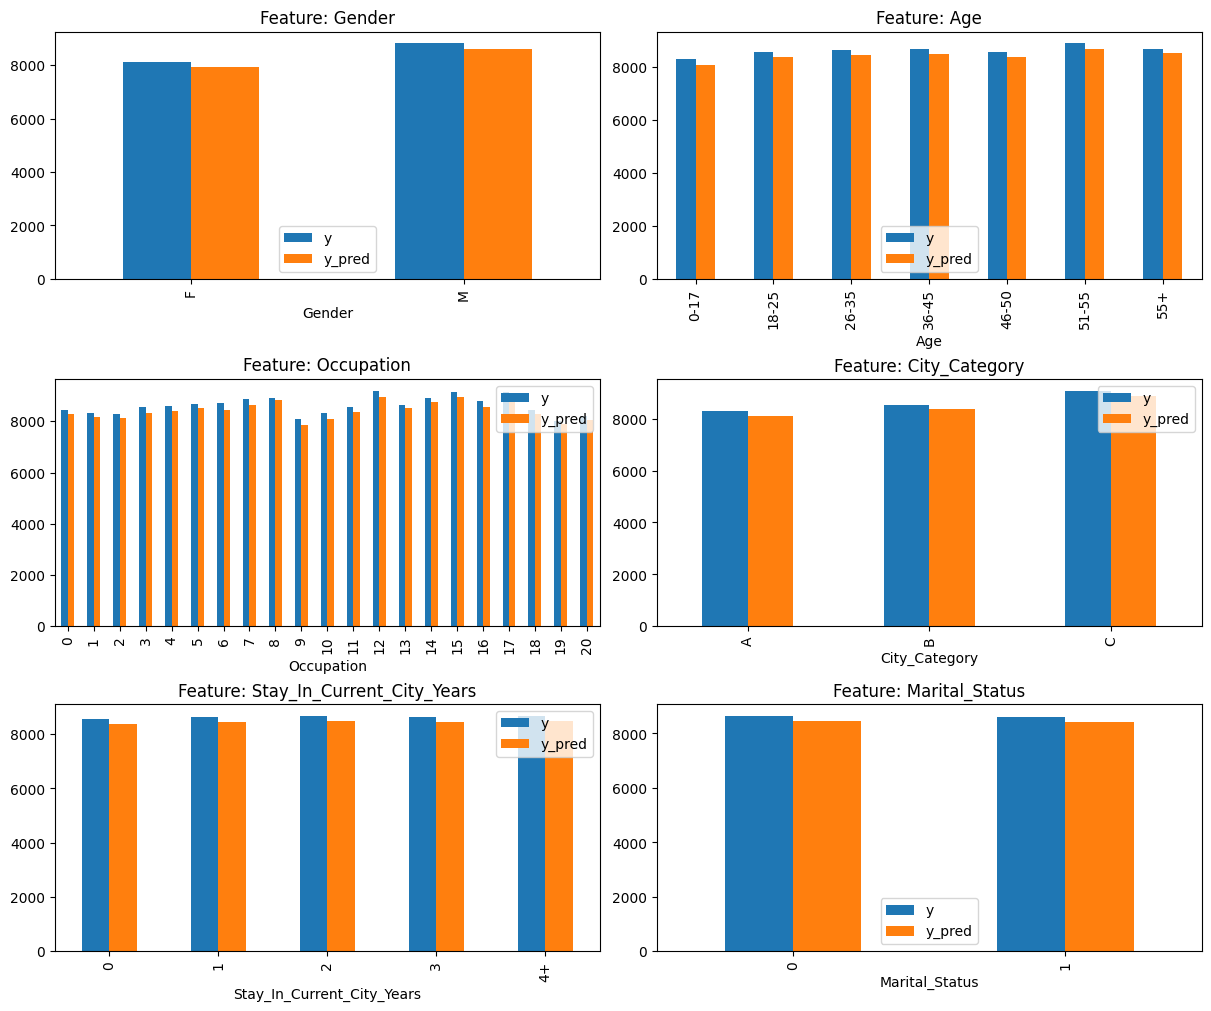

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), constrained_layout = True)


for i,f in enumerate(['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']):
    df.groupby(f)[['y','y_pred']].mean().plot(ax=axes[i//2, i%2] ,kind='bar', title=f'Feature: {f}')

<Axes: title={'center': 'Recommendation - SVD'}, xlabel='y', ylabel='y_pred'>

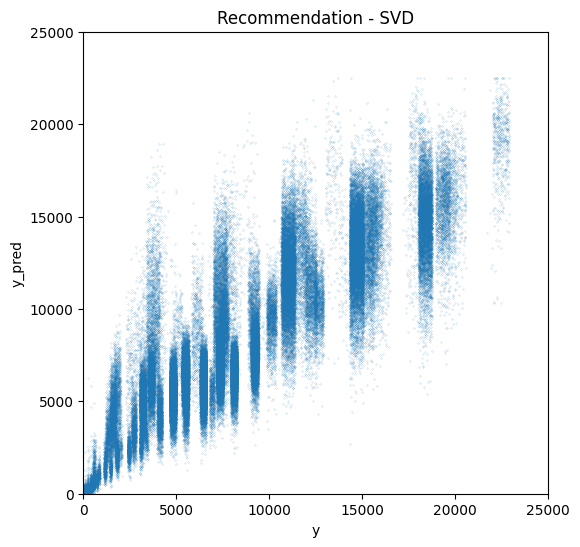

In [9]:
df[['y', 'y_pred']].plot.scatter(x='y', 
                                 y='y_pred', 
                                 xlim=[0,25000], 
                                 ylim=[0,25000], 
                                 s=0.01, 
                                 title='Recommendation - SVD',
                                 figsize=(6,6))